In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Looking at daily measurments in the Nettfart.no data

## import 

In [2]:
counties = ['Oslo County', 'Viken', 'Vestland', 'Nordland', 'Trøndelag', 'Innlandet',
 'Vestfold og Telemark', 'Møre og Romsdal', 'Agder', 'Rogaland',
 'Troms og Finnmark',]
dfs = {}
for c in counties:
    file_path = '../datasets/county-aggregated/' + c.replace(' ', '_') + '_day_aggr.csv' 
    df = pd.read_csv(file_path , index_col="Tid", parse_dates=True)
    df.rename(columns = {"('quantile_down', 0.75)": "quant_down_0.75", 
                         "('quantile_down', 0.25)": "quant_down_0.25", 
                         "('quantile_up', 0.75)": "quant_up_0.75",
                         "('quantile_up', 0.25)": "quant_up_0.25",
                         "('quantile_delay', 0.75)": "quant_delay_0.75",
                         "('quantile_delay', 0.25)": "quant_delay_0.25"}, inplace =True)
    #look at 2015-2020
    df = df.loc['2015-01-01': '2020-12-31']
    dfs[c] = df
dfs[counties[0]].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2192 entries, 2015-01-01 to 2020-12-31
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   median_down       2190 non-null   float64
 1   median_up         2190 non-null   float64
 2   median_delay      2190 non-null   float64
 3   mean_down         2190 non-null   float64
 4   mean_up           2190 non-null   float64
 5   mean_delay        2190 non-null   float64
 6   std_down          2189 non-null   float64
 7   std_up            2189 non-null   float64
 8   std_delay         2189 non-null   float64
 9   quant_down_0.25   2190 non-null   float64
 10  quant_down_0.75   2190 non-null   float64
 11  quant_up_0.25     2190 non-null   float64
 12  quant_up_0.75     2190 non-null   float64
 13  quant_delay_0.25  2190 non-null   float64
 14  quant_delay_0.75  2190 non-null   float64
 15  count             2192 non-null   int64  
dtypes: float64(15), int64(1)


I want to do a analysis of the peak based on number of measuments each day. Hypothesis is that a spike measurments that vastly differs 
from earlier measurments, is caused by some event. These type events are yet to be determined, but could be network core problems, DDoS attacks, or other national envents. Peaks in several geographical areas can indicate a event not bound by location and lessens the probability that the peak is noise.

In [3]:
#combine all area counts into one DF
date_index = pd.date_range(start='2015-01-01', end='2020-12-31', freq='D')
count_area_df = pd.DataFrame(index=pd.DatetimeIndex(data=date_index))


count_series = [dfs[county]['count'] for county in counties]
count_df = pd.concat(count_series, axis=1, ignore_index=True)
count_df.columns = counties
count_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2192 entries, 2015-01-01 to 2020-12-31
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype
---  ------                --------------  -----
 0   Oslo County           2192 non-null   int64
 1   Viken                 2192 non-null   int64
 2   Vestland              2192 non-null   int64
 3   Nordland              2192 non-null   int64
 4   Trøndelag             2192 non-null   int64
 5   Innlandet             2192 non-null   int64
 6   Vestfold og Telemark  2192 non-null   int64
 7   Møre og Romsdal       2192 non-null   int64
 8   Agder                 2192 non-null   int64
 9   Rogaland              2192 non-null   int64
 10  Troms og Finnmark     2192 non-null   int64
dtypes: int64(11)
memory usage: 205.5 KB


In [4]:
# rolling mean of the last month in all counties
rolling_count_df = count_df.rolling(60).mean().bfill()
rolling_std_df = count_df.rolling(60).std().bfill()

# combine to one df
rolling_count_df = pd.merge(rolling_count_df, rolling_std_df, left_index=True, right_index=True, suffixes=('_mean', '_std'))
rolling_count_df = rolling_count_df.join(count_df)
rolling_count_df

,Oslo County_mean,Viken_mean,Vestland_mean,Nordland_mean,Trøndelag_mean,Innlandet_mean,Vestfold og Telemark_mean,Møre og Romsdal_mean,Agder_mean,Rogaland_mean,...,Viken,Vestland,Nordland,Trøndelag,Innlandet,Vestfold og Telemark,Møre og Romsdal,Agder,Rogaland,Troms og Finnmark
Tid,,,,,,,,,,,,,,,,,,,,,
2015-01-01,685.183333,668.033333,498.450000,162.966667,350.166667,355.800000,255.733333,221.416667,189.816667,221.983333,...,488,340,114,240,266,185,187,148,154,91
2015-01-02,685.183333,668.033333,498.450000,162.966667,350.166667,355.800000,255.733333,221.416667,189.816667,221.983333,...,707,599,179,381,390,240,242,208,230,169
2015-01-03,685.183333,668.033333,498.450000,162.966667,350.166667,355.800000,255.733333,221.416667,189.816667,221.983333,...,561,421,130,256,274,226,244,172,189,144
2015-01-04,685.183333,668.033333,498.450000,162.966667,350.166667,355.800000,255.733333,221.416667,189.816667,221.983333,...,581,418,188,275,292,237,171,144,213,215
2015-01-05,685.183333,668.033333,498.450000,162.966667,350.166667,355.800000,255.733333,221.416667,189.816667,221.983333,...,700,497,218,354,380,207,259,239,243,217
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-27,1036.833333,926.966667,460.883333,126.150000,355.850000,297.133333,273.083333,145.916667,202.116667,232.500000,...,668,397,97,193,328,201,136,181,192,121
2020-12-28,1028.633333,923.933333,459.850000,126.150000,356.183333,296.683333,271.583333,146.516667,201.433333,234.250000,...,761,488,124,289,299,222,160,185,317,159
2020-12-29,1026.900000,921.933333,463.750000,127.033333,354.666667,295.233333,270.883333,146.216667,201.750000,234.783333,...,860,679,180,282,245,280,122,231,175,125


In [5]:
# making threshold based on standard deviation for each area- Threshold at 2 times std. 

for county in counties:
    mean= rolling_count_df[ county +'_mean']
    std = rolling_count_df[ county +'_std']
    
    # peak thrs
    rolling_count_df[ county +'_trh'] =2*mean +std
    
    # making a lower threshold to make a "high" class that is not a peak
    rolling_count_df[ county +'_ltrh'] =mean +std


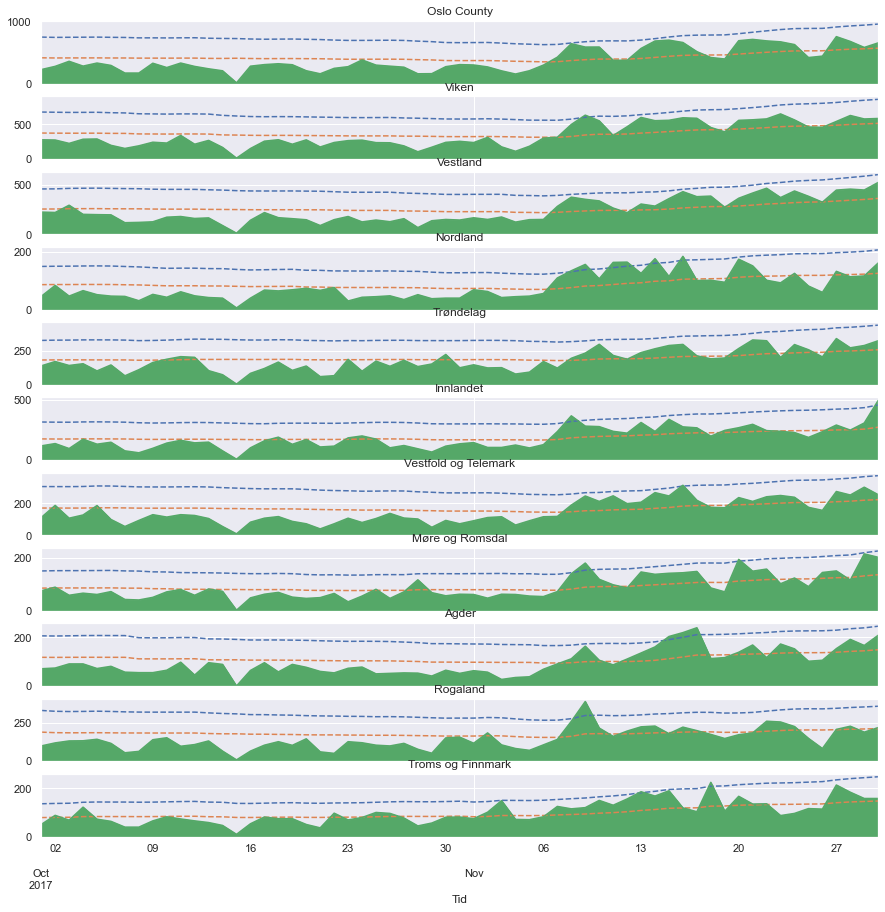

In [6]:
# plotting a month for visuals
current_data = rolling_count_df.loc['2017-10':'2017-11']
sns.set_theme(style='darkgrid')
numb_plts = len(counties)
fig, axes = plt.subplots(nrows=numb_plts, sharex=True, figsize=(15,15))
for i in range(numb_plts):
    area = counties[i]
    axes[i].set_title(area)
   # current_data[area +'_mean'].plot( ax= axes[i], style="--")
    current_data[area + '_trh'].plot(ax=axes[i], style="--")
    current_data[area + '_ltrh'].plot(ax=axes[i], style="--")
    current_data[area].plot(ax=axes[i], kind='area')

In [7]:
# apply threshold to functions and record peaks 
# peak if larger than threshold
# high if larger than low threshold
# and the area must have over 10 measuments that day to be classified as high or  

# Then map to numeric values: 2 for peak, 1 for high, 0 for other (low/normal) 


def numeric_mapping(row, area):
    if row[area+'_peak']:
        return 2
    elif row[area+'_high']:
        return 1
    else:
        return 0


peaks_df = pd.DataFrame(index=pd.DatetimeIndex(date_index))
for c in counties:
    # check for peak and high values and return boolean series
    peaks_df[c+'_peak'] = (rolling_count_df[c+'_trh'] < rolling_count_df[c] ) & (rolling_count_df[c] > 10)
    peaks_df[c+'_high'] = (rolling_count_df[c+'_ltrh'] < rolling_count_df[c] ) & (rolling_count_df[c] > 10)
    
    # map boolean to numbers
    peaks_df[c] = peaks_df.apply( lambda row : numeric_mapping(row , c), axis=1)

# only return numeric values
peaks_df = peaks_df[counties]

peaks_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2192 entries, 2015-01-01 to 2020-12-31
Freq: D
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype
---  ------                --------------  -----
 0   Oslo County           2192 non-null   int64
 1   Viken                 2192 non-null   int64
 2   Vestland              2192 non-null   int64
 3   Nordland              2192 non-null   int64
 4   Trøndelag             2192 non-null   int64
 5   Innlandet             2192 non-null   int64
 6   Vestfold og Telemark  2192 non-null   int64
 7   Møre og Romsdal       2192 non-null   int64
 8   Agder                 2192 non-null   int64
 9   Rogaland              2192 non-null   int64
 10  Troms og Finnmark     2192 non-null   int64
dtypes: int64(11)
memory usage: 205.5 KB


In [8]:
#count number of simotanous peaks
num_of_peaks = peaks_df[peaks_df==2].count(axis=1)
num_of_peaks.value_counts()

0     2162
1       21
4        3
3        3
2        2
10       1
dtype: int64

In [9]:
#count number of simoultanous highs

num_of_highs = peaks_df[peaks_df==1].count(axis=1)
num_of_highs.value_counts()

0     989
1     370
2     256
3     192
4     119
5      80
6      50
7      46
8      36
9      22
10     21
11     11
dtype: int64

In [10]:
# sumerisze a score across counties for each day. High=1 peak=2
count_scores = peaks_df.sum(axis=1)
count_scores.value_counts(ascending=True)

21      1
13      2
14      3
15      3
12      4
11     14
9      17
10     20
8      32
7      46
6      49
5      78
4     119
3     193
2     256
1     367
0     988
dtype: int64

In [11]:
count_scores[count_scores > 13]

2015-08-03    15
2016-02-01    21
2017-11-09    15
2017-11-16    14
2020-03-16    15
2020-03-18    14
2020-03-19    14
dtype: int64

<AxesSubplot:>

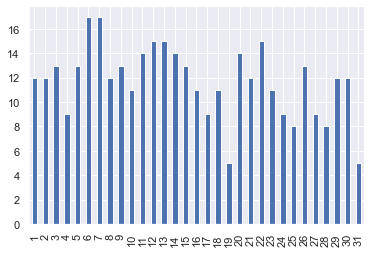

In [12]:
peaks_df['Trøndelag'].groupby(count_scores.index.day).sum().plot(kind='bar')

<AxesSubplot:>

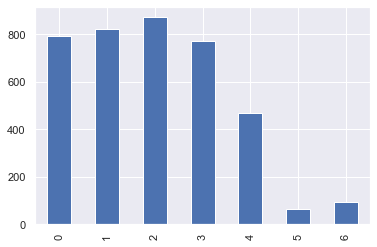

In [13]:
count_scores.groupby(count_scores.index.dayofweek).sum().plot(kind='bar')


In [14]:
len(counties)

11

## Look at the one extreme high

One day is shown to have peaks in 10 out of eleven counties, this is six more than the second highest peak value.
This needs to be investigated.

In [15]:
num_of_peaks[num_of_peaks > 1]

2015-08-03     4
2016-02-01    10
2017-11-08     2
2017-11-09     4
2017-11-16     3
2020-03-16     4
2020-03-17     2
2020-03-18     3
2020-03-19     3
dtype: int64

First of febuary 2016

In [16]:
df = pd.read_csv("../datasets/Nettfart_daily_web.csv" , index_col="Tid", parse_dates=True)
# convert from kbit/s to Mbit/s
df = df/1000
df[['median_delay',
    'count', 
    'mean_delay', 
    'std_delay', 
    "('quantile_delay', 0.25)'",
    "('quantile_delay', 0.75)"]] = df[['median_delay', 
                                       'count', 
                                       'mean_delay', 
                                       'std_delay',
                                       "('quantile_delay', 0.25)", 
                                       "('quantile_delay', 0.75)"]]*1000
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3288 entries, 2012-01-01 to 2020-12-31
Data columns (total 17 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   median_down                3287 non-null   float64
 1   median_up                  3287 non-null   float64
 2   median_delay               3287 non-null   float64
 3   mean_down                  3287 non-null   float64
 4   mean_up                    3287 non-null   float64
 5   mean_delay                 3287 non-null   float64
 6   std_down                   3286 non-null   float64
 7   std_up                     3286 non-null   float64
 8   std_delay                  3286 non-null   float64
 9   ('quantile_down', 0.25)    3287 non-null   float64
 10  ('quantile_down', 0.75)    3287 non-null   float64
 11  ('quantile_up', 0.25)      3287 non-null   float64
 12  ('quantile_up', 0.75)      3287 non-null   float64
 13  ('quantile_delay', 0.25)   328

<AxesSubplot:xlabel='Tid'>

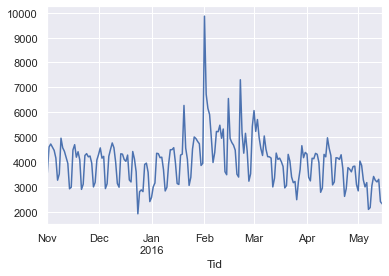

In [17]:
df.loc['2015-11-01': '2016-05-15' ]['count'].plot()


<AxesSubplot:xlabel='Tid'>

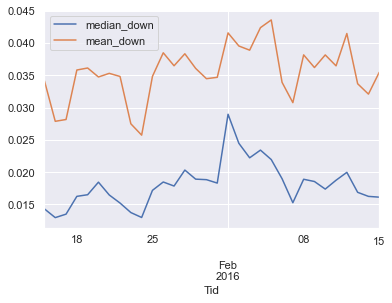

In [18]:
df.loc['2016-01-15': '2016-02-15' ][['median_down', 'mean_down']].plot()


<AxesSubplot:xlabel='Tid'>

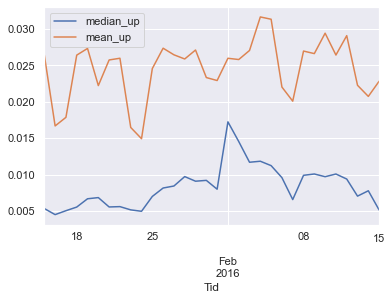

In [19]:
df.loc['2016-01-15': '2016-02-15' ][['median_up', 'mean_up']].plot()

<AxesSubplot:xlabel='Tid'>

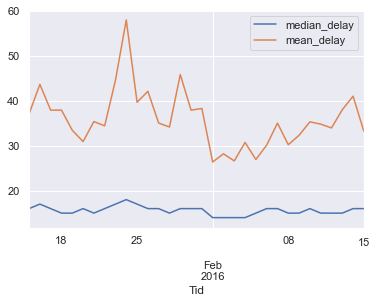

In [20]:
df.loc['2016-01-15': '2016-02-15' ][['median_delay', 'mean_delay']].plot()

Increase in median up/down speed, a little drop in mean delay, not as significant.

<AxesSubplot:xlabel='Tid'>

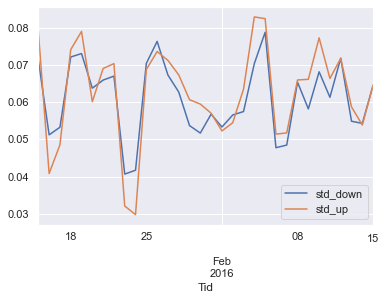

In [21]:
df.loc['2016-01-15': '2016-02-15' ][['std_down', 'std_up']].plot()


<AxesSubplot:xlabel='Tid'>

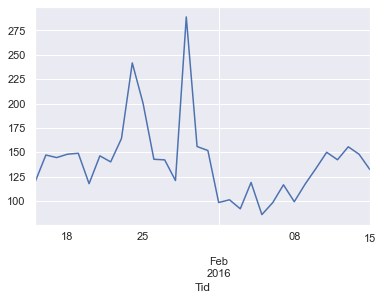

In [22]:
df.loc['2016-01-15': '2016-02-15' ]['std_delay'].plot()


No significant change in std, a drop in std for delay

In [23]:
# import full 2016 web data, to look into Feb 1st. peak
n13 = pd.read_csv('../datasets/nettfart-2016/nettfart-2016.csv', sep=";", header= None)
n13.columns = ["ID","Ned","Opp","Delay (ping)", "Tid", "ISP", "By", "Fylke", "Land", "Bredde", "Lengde", "test_id", "Isp_id", "prod_id","User platform", "nope", "ip_ver" ]
n13["Tid"] = pd.to_datetime(n13["Tid"])
n13.index=n13["Tid"]
n13.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1262633 entries, 2016-01-01 00:01:32 to 2016-12-31 23:56:45
Data columns (total 17 columns):
 #   Column         Non-Null Count    Dtype         
---  ------         --------------    -----         
 0   ID             1262633 non-null  int64         
 1   Ned            1262633 non-null  int64         
 2   Opp            1262633 non-null  int64         
 3   Delay (ping)   1262633 non-null  int64         
 4   Tid            1262633 non-null  datetime64[ns]
 5   ISP            1262633 non-null  object        
 6   By             1071400 non-null  object        
 7   Fylke          1085993 non-null  object        
 8   Land           1259162 non-null  object        
 9   Bredde         1262475 non-null  float64       
 10  Lengde         1262475 non-null  float64       
 11  test_id        1262633 non-null  float64       
 12  Isp_id         1262605 non-null  float64       
 13  prod_id        349702 non-null   float64       
 14  U

In [24]:
# parse user agent
import httpagentparser

n13['User platform'] =n13['User platform'].apply(lambda s: httpagentparser.simple_detect(s))


In [25]:
#extract OS and broser from user platform information. 
n13['OS'] = n13['User platform'].apply(lambda s: s[0])
n13['Browser'] = n13['User platform'].apply(lambda s: s[1])

Text(0, 0.5, 'Num measurements')

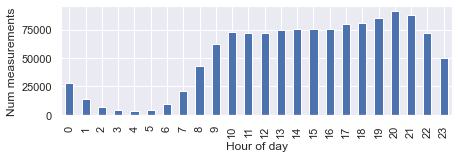

In [26]:
# ditrubutions of measurments total
hour_of_day_full = n13.groupby(n13['Tid'].dt.hour)['Ned'].count()

fig, ax= plt.subplots( figsize=(7, 2))
hour_of_day_full.plot(kind='bar', ax=ax)
ax.set_xlabel("Hour of day")
ax.set_ylabel("Num measurements")

Text(0, 0.5, 'Num measurements')

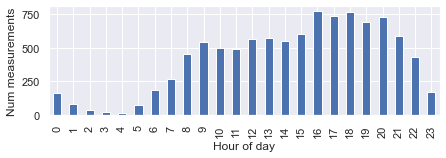

In [27]:
feb_first = n13.loc['2016-02-01']
feb_first_count = feb_first.groupby(feb_first['Tid'].dt.hour)['Ned'].count()

fig, ax= plt.subplots( figsize=(7, 2))
feb_first_count.plot(kind='bar', ax=ax)
ax.set_xlabel("Hour of day")
ax.set_ylabel("Num measurements")

No large devience from the normal diistribution of measurments during the day. 

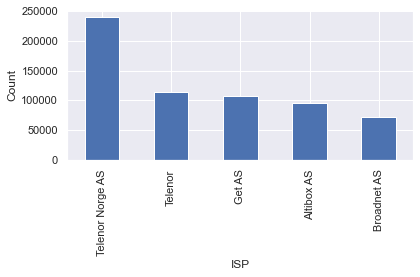

In [28]:
n13['ISP'].value_counts()[:5].plot(kind='bar')
plt.xlabel("ISP")
plt.ylabel("Count")
plt.tight_layout()
#plt.savefig("figs/peak_det/2016_isp_count")

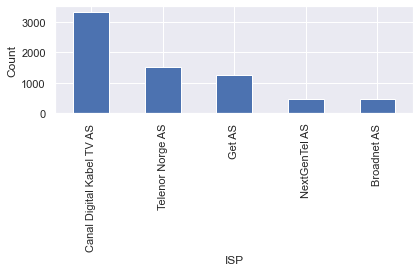

In [29]:
feb_first['ISP'].value_counts().iloc[:5].plot(kind='bar')
plt.xlabel("ISP")
plt.ylabel("Count")
plt.tight_layout()

#plt.savefig("figs/peak_det/feb_first_isp_count")

<AxesSubplot:>

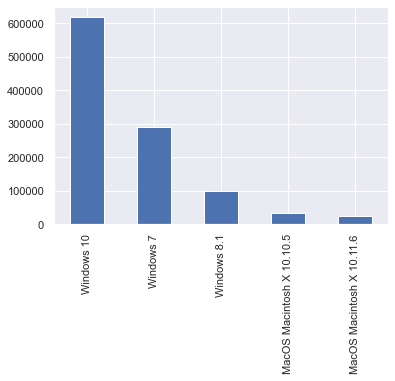

In [30]:
n13['OS'].value_counts().iloc[:5].plot(kind='bar')

<AxesSubplot:>

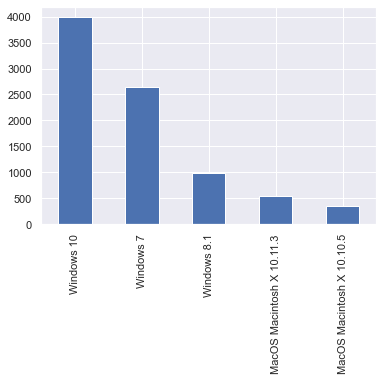

In [31]:
feb_first['OS'].value_counts().iloc[:5].plot(kind='bar')

<AxesSubplot:>

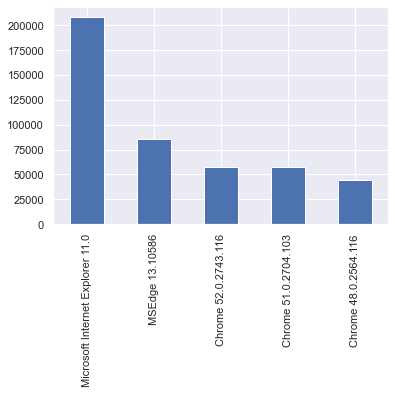

In [32]:
n13['Browser'].value_counts().iloc[:5].plot(kind='bar')

<AxesSubplot:>

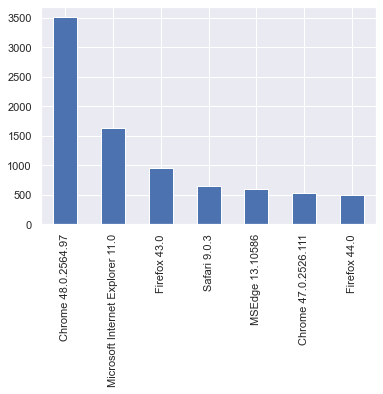

In [33]:
feb_first['Browser'].value_counts().iloc[:7].plot(kind='bar')

# Look at november 2017 peaks 

<AxesSubplot:xlabel='Tid'>

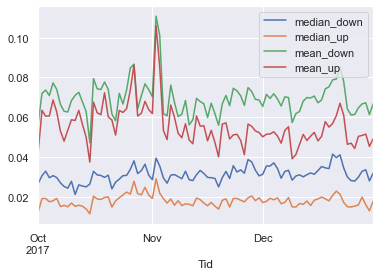

In [34]:
df.loc['2017-10':'2017-12'][['median_down','median_up', 'mean_down', 'mean_up']].plot()

<AxesSubplot:xlabel='Tid'>

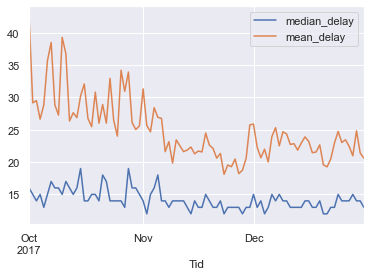

In [35]:
df.loc['2017-10':'2017-12'][['median_delay', 'mean_delay']].plot()

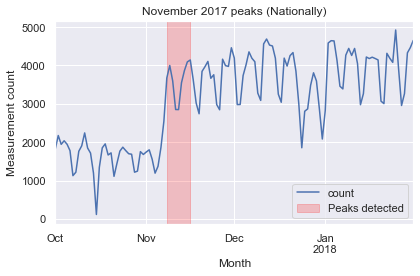

In [36]:
fig, ax = plt.subplots()

df.loc['2017-10':'2018-01']['count'].plot(ax=ax)
ax.set_xlabel('Month')
ax.set_ylabel('Measurement count')
plt.title("November 2017 peaks (Nationally)")
ax.axvspan(np.datetime64('2017-11-08'), np.datetime64('2017-11-16'), color='red', alpha=0.2, clip_on=True, label='Peaks detected')
plt.legend()

plt.tight_layout()
#plt.savefig('figs/peak_det/nov2017_peaks')

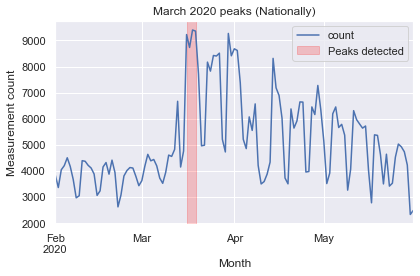

In [37]:
fig, ax = plt.subplots()

df.loc['2020-02':'2020-05']['count'].plot(ax=ax)
ax.set_xlabel('Month')
ax.set_ylabel('Measurement count')
ax.axvspan(np.datetime64('2020-03-16'), np.datetime64('2020-03-19'), color='red', alpha=0.2, clip_on=True, label='Peaks detected')

plt.title("March 2020 peaks (Nationally)")
plt.legend()
plt.tight_layout()
#plt.savefig('figs/peak_det/march2020_peaks')

A doubeling in total measurments in beginning of nov 2018. Likely source of the peaks. What is the reason? Change in Netfart tool? 

<AxesSubplot:xlabel='Tid'>

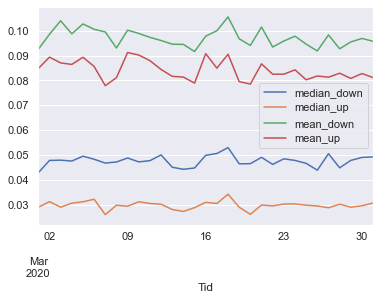

In [38]:
df.loc['2020-03'][['median_down','median_up', 'mean_down', 'mean_up']].plot()

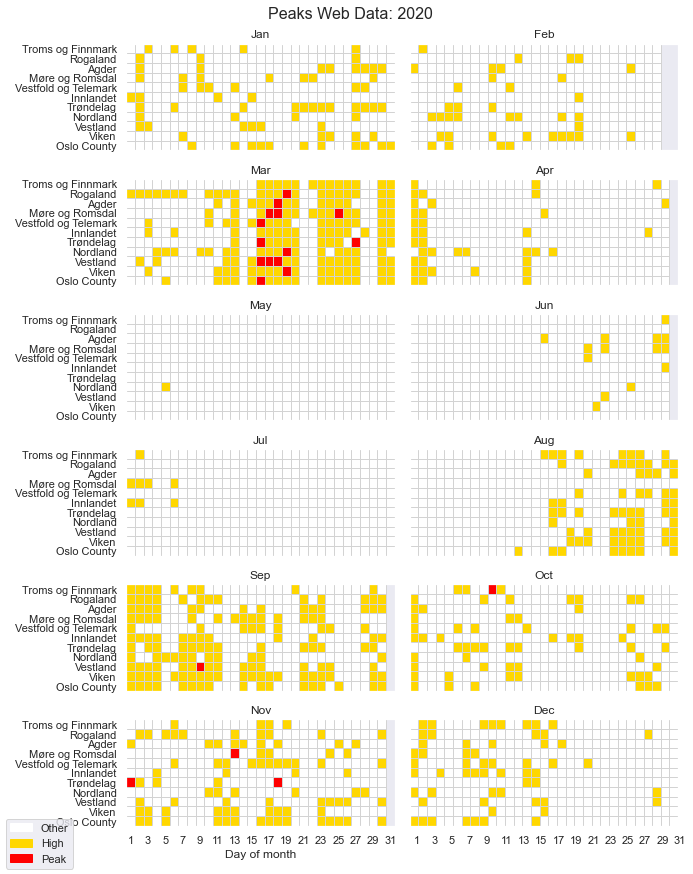

In [40]:
import calendar
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap
fig, ax = plt.subplots( sharex=True, sharey=True, figsize=(9.69,12.27), nrows =6, ncols= 2)
colors =["white","gold","red"]
labels = ["Other", "High", "Peak", "ya"]
year=2020
row = 0
for i in range(12):
        col = i%2
        month = i+1
        s = str(month) if month >= 10 else '0'+ str(month)
        data = peaks_df.loc[str(year)+"-"+s]
        dif_vals = data.max().max()+1
        cmap1 =ListedColormap(colors[:dif_vals])
        ax[row, col].grid(False)
        x = np.arange(len(data))+1
        y = np.arange(11) + 1
        X,Y = np.meshgrid(x,y)
        ax[row, col].set_prop_cycle(color=cmap1.colors[:-1])
        ax[row, col].pcolormesh(X, Y, data.values.transpose(), cmap=cmap1, edgecolor = 'lightgray', linewidth = 0.5)
        ax[row, col].set_title(calendar.month_abbr[month])
        row+=col
#plot legend
handels= []
for i in range(len(colors)):
    handels.append(mpatches.Patch(color=colors[i], label=labels[i]))
fig.legend(handles=handels, loc='lower left')

# handle ticks
plt.xticks(ticks=list(range(1,32, 2)), ha='left')
plt.yticks(ticks=list(range(1,12, 1)), ha='left', labels=counties)
fig.suptitle('Peaks Web Data: ' + str(year), fontsize=16)

ax[5,0].set_xlabel("Day of month")

plt.tight_layout()
#plt.savefig('figs/peak_det/full_years/web_peaks_' + str(year))
plt.show()